In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
from coresets.clustering import kcenters_greedy
from coresets.clustering import kcenters_robust_girdhar
from coresets.clustering import utils

In [3]:
# Global params and helpers
seed = 42
torch.manual_seed(seed)

device="cpu"

def sample_from_circle(num_samples, r):
    sampled_radius = r * torch.sqrt(torch.rand((num_samples), device=device))
    sampled_theta = torch.rand((num_samples), device=device) * 2 * 3.14159
    sampled_x = sampled_radius * torch.cos(sampled_theta)
    sampled_y = sampled_radius * torch.sin(sampled_theta)
    samples = torch.vstack((sampled_x, sampled_y)).T
    return samples

def sample_from_ring(num_samples, r):
    sampled_radius = r
    sampled_theta = torch.rand((num_samples), device=device) * 2 * 3.14159
    sampled_x = sampled_radius * torch.cos(sampled_theta)
    sampled_y = sampled_radius * torch.sin(sampled_theta)
    samples = torch.vstack((sampled_x, sampled_y)).T
    return samples


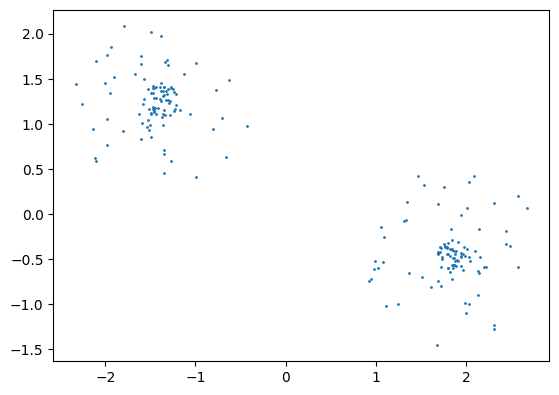

In [4]:
# Generate artificial clusters, the dumb 2D uniform way for now


# alpha is inter-cluster separation, beta is intra-cluster separation and gamma is intra-cluster outliers (noise)
# alpha > gamma > beta, clear clusters emerge if alpha >> gamma
alpha = 2
beta = 0.2
gamma = 1

n_clusters = 2
n_points = 50 # points per cluster
n_outliers = 50 # outliers per cluster

# Generate centers
centers = sample_from_circle(n_clusters, alpha)

# Generate points
points = []
labels = []
for c in range(len(centers)):
    # Generate points per cluster
    new_points = sample_from_circle(n_points , beta) + centers[c]
    labels.append(torch.ones((n_points), device=device) * c)
    points.append(new_points)

    # Generate outliers per cluster
    outliers = sample_from_circle(n_outliers, gamma) + centers[c]
    labels.append(torch.ones((n_outliers), device=device) * c)
    points.append(outliers)

# Concatenate points
points = torch.concat(points)
plt.plot(points[:, 0].cpu(), points[:, 1].cpu(), 'o', markersize=1)
plt.gca().set_aspect('equal')  # More explicit way


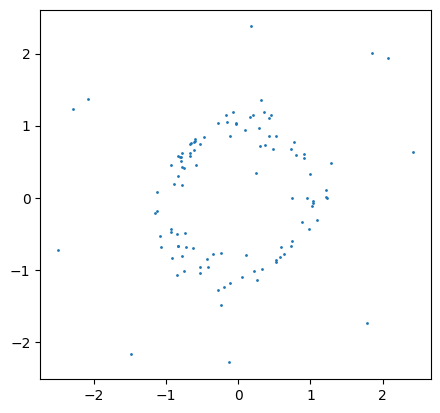

In [5]:
# Generate artificial ring clusters, the dumb 2D uniform way for now

# alpha is inter-cluster separation, beta is intra-cluster separation and gamma is intra-cluster outliers (noise)
# gamma > alpha > beta, clear clusters emerge if alpha >> gamma
alpha = 1
beta = 0.2
gamma = 2.5

n_points = 100 # points per cluster
n_outliers = 10 # outliers per cluster

# Generate points
centers = sample_from_ring(n_points, alpha)
outliers = sample_from_ring(n_outliers, gamma)

points = centers + torch.randn((n_points, 1), device=device) * beta
outliers = outliers + torch.randn((n_outliers, 1), device=device) * beta

points = torch.concat((points, outliers))
plt.plot(points[:, 0].cpu(), points[:, 1].cpu(), 'o', markersize=1)
plt.gca().set_aspect('equal')  # More explicit way


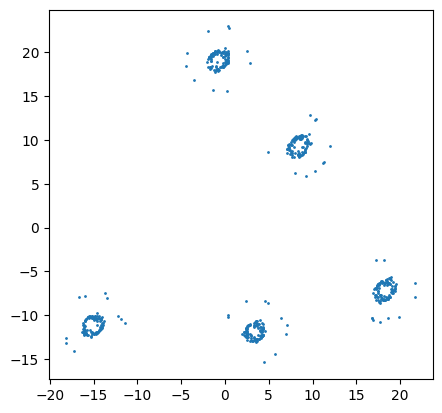

In [6]:
# Generate multiple artificial ring clusters, the dumb 2D uniform way for now
seed = 42
torch.manual_seed(seed)

# alpha is inter-cluster separation, beta is intra-cluster separation and gamma is intra-cluster outliers (noise)
# delta > gamma*2 > alpha > beta, clear clusters emerge if alpha >> gamma
alpha = 1
beta = 0.2
gamma = 3.5
delta = 20

n_clusters = 5
n_points = 100 # points per cluster
n_outliers = 10 # outliers per cluster

device="cpu"

# Generate points
centers = sample_from_circle(n_clusters, delta)
points = torch.tensor([], device=device)

for i in range(n_clusters):
    subpoints = sample_from_ring(n_points, alpha) + centers[i]
    outliers = sample_from_ring(n_outliers, gamma) + centers[i]

    subpoints = subpoints + torch.randn((n_points, 1), device=device) * beta
    outliers = outliers + torch.randn((n_outliers, 1), device=device) * beta

    points = torch.concat((points, subpoints, outliers))

plt.plot(points[:, 0].cpu(), points[:, 1].cpu(), 'o', markersize=1)
plt.gca().set_aspect('equal')  # More explicit way


Max surprise:  tensor(0.4795)
Mean surprise:  tensor(0.2020)


/tmp/ipykernel_104482/3133345604.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  surprise, surprise_inds = utils.get_elementwise_surprise(points, torch.tensor(kc, device=device), dist_func="l2", device=device)


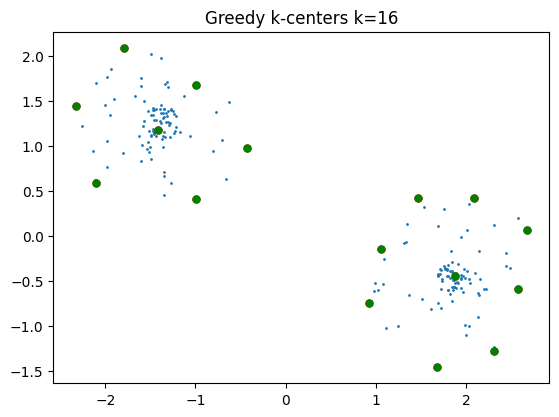

In [5]:
# Greedy K-centers
k = 16

kc_inds, kc = kcenters_greedy.kcenters_greedy(points, k, dist_func="l2", device=device)
kci = points[kc_inds,...]
plt.plot(points[:, 0].cpu(), points[:, 1].cpu(), 'o', markersize=1)
plt.plot(kc[:, 0].cpu(), kc[:, 1].cpu(), 'o', markersize=5, color='red')
plt.plot(kci[:, 0].cpu(), kci[:, 1].cpu(), 'o', markersize=5, color='green')
plt.gca().set_aspect('equal')  # More explicit way
plt.title(f"Greedy k-centers k={k}")

surprise, surprise_inds = utils.get_elementwise_surprise(points, torch.tensor(kc, device=device), dist_func="l2", device=device)
max_surprise = torch.max(surprise)
mean_surprise = torch.mean(surprise)

print("Max surprise: ", max_surprise)
print("Mean surprise: ", mean_surprise)


Max surprise:  tensor(0.4795)
Mean surprise:  tensor(0.2020)


/tmp/ipykernel_104482/2186482658.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  surprise, surprise_inds = utils.get_elementwise_surprise(points, torch.tensor(kc, device=device), dist_func="l2", device=device)


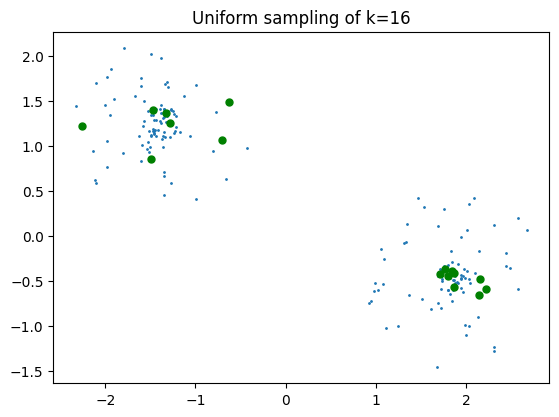

In [6]:
# Uniform
k = 16
kc_inds = torch.multinomial(torch.ones(len(points)), k, replacement=False)
kci = points[kc_inds,...]
plt.plot(points[:, 0].cpu(), points[:, 1].cpu(), 'o', markersize=1)
plt.plot(kci[:, 0].cpu(), kci[:, 1].cpu(), 'o', markersize=5, color='green')
plt.gca().set_aspect('equal')  # More explicit way
plt.title(f"Uniform sampling of k={k}")

surprise, surprise_inds = utils.get_elementwise_surprise(points, torch.tensor(kc, device=device), dist_func="l2", device=device)
max_surprise = torch.max(surprise)
mean_surprise = torch.mean(surprise)

print("Max surprise: ", max_surprise)
print("Mean surprise: ", mean_surprise)

Initializing...
Searching for threshold...


 94%|█████████▍| 15/16 [00:00<00:00, 1966.02it/s]

16
Max surprise:  tensor(0.8842)
Mean surprise:  tensor(0.2370)


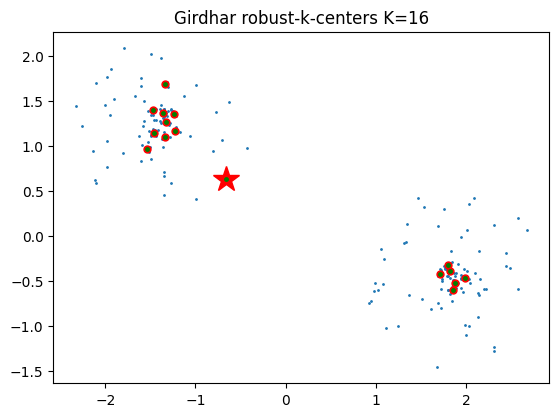

In [7]:
# Gamma K-centers (Girdhar)
import time
torch.manual_seed(time.time())
k = 16

# d = torch_summarization.get_pairwise_distances(points, points, dist_func="l2", device=device)
# d.fill_diagonal_(float("inf"))
# print(torch.mean(d))
# kc_inds, kc = torch_summarization.gamma_kcenters_index(points, k, gamma=0.8, thresh=0.2353671875, dist_func="l2", init_samples="smallest_mean", device=device, stop_at_k=False)
# print(kc.shape[0])
# kci = points[kc_inds,...]
# kc = torch.vstack(kc)[:n_clusters,:]
points = points.to(device)
kc_inds, kc = kcenters_robust_girdhar.kcover(points.to(device), k, gamma=0.4, dist_func="l2", device=device)
print(kc.shape[0])
kci = points[kc_inds,...]

plt.plot(points[:, 0].cpu(), points[:, 1].cpu(), 'o', markersize=1)
plt.plot(kc[:, 0].cpu(), kc[:, 1].cpu(), 'o', markersize=5, color="red")
plt.plot(kc[0, 0].cpu(), kc[0, 1].cpu(), '*', markersize=19, color="red")
plt.plot(kci[:, 0].cpu(), kci[:, 1].cpu(), '.', markersize=5, color='green')

plt.gca().set_aspect('equal')  # More explicit way
plt.title(f"Girdhar robust-k-centers K={k}")

surprise, surprise_inds = utils.get_elementwise_surprise(points, kc, dist_func="l2", device=device)
max_surprise = torch.max(surprise)
mean_surprise = torch.mean(surprise)

print("Max surprise: ", max_surprise)
print("Mean surprise: ", mean_surprise)

(200, 2)
Max surprise:  tensor(0.5756)
Mean surprise:  tensor(0.1556)


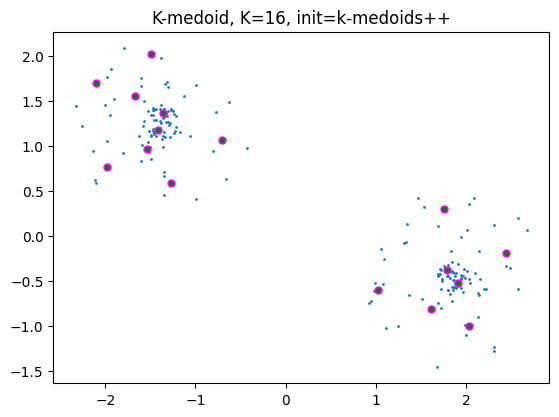

In [8]:
# K-mediods
from sklearn_extra.cluster import KMedoids

points_np = points.cpu().numpy()
print(points_np.shape)
k = 16
km = KMedoids(n_clusters=k, random_state=None, init="k-medoids++").fit(points_np)
# km = KMedoids(n_clusters=k, random_state=None, init="heuristic").fit(points_np)
kc = km.cluster_centers_
kci = points_np[km.medoid_indices_,...]

plt.plot(points[:, 0].cpu(), points[:, 1].cpu(), 'o', markersize=1)
plt.plot(kc[:, 0], kc[:, 1], 'o', markersize=5, color="magenta")
plt.plot(kci[:, 0], kci[:, 1], '.', markersize=5, color='green')

# plt.plot(kc[0, 0], kc[0, 1], '*', markersize=19, color="red")
plt.gca().set_aspect('equal')  # More explicit way
plt.title(f"K-medoid, K={k}, init={km.init}")

surprise, surprise_inds = utils.get_elementwise_surprise(points, torch.tensor(kc, device=device), dist_func="l2", device=device)
max_surprise = torch.max(surprise)
mean_surprise = torch.mean(surprise)

print("Max surprise: ", max_surprise)
print("Mean surprise: ", mean_surprise)

(200, 2)
Max surprise:  tensor(0.6852)
Mean surprise:  tensor(0.1857)


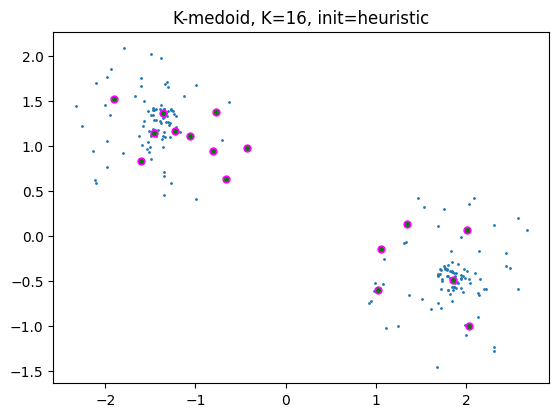

In [9]:
# K-mediods
from sklearn.cluster import DBSCAN

points_np = points.cpu().numpy()
print(points_np.shape)
k = 16
# km = KMedoids(n_clusters=k, random_state=None, init="k-medoids++").fit(points_np)
db = DBSCAN(eps=0.5, min_samples=5).fit(points_np)
km = KMedoids(n_clusters=k, random_state=None, init="heuristic").fit(points_np)
kc = km.cluster_centers_
kci = points_np[km.medoid_indices_,...]

plt.plot(points[:, 0].cpu(), points[:, 1].cpu(), 'o', markersize=1)
plt.plot(kc[:, 0], kc[:, 1], 'o', markersize=5, color="magenta")
plt.plot(kci[:, 0], kci[:, 1], '.', markersize=5, color='green')

# plt.plot(kc[0, 0], kc[0, 1], '*', markersize=19, color="red")
plt.gca().set_aspect('equal')  # More explicit way
plt.title(f"K-medoid, K={k}, init={km.init}")

surprise, surprise_inds = utils.get_elementwise_surprise(points, torch.tensor(kc, device=device), dist_func="l2", device=device)
max_surprise = torch.max(surprise)
mean_surprise = torch.mean(surprise)

print("Max surprise: ", max_surprise)
print("Mean surprise: ", mean_surprise)